##### Modelo SEIR (Susceptibles, Expuestos, Infecciosos, Recuperados) + Fallecidos

In [1]:
import numpy as np
import scipy
import scipy.integrate

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu):
    S, E, I, R, F = SEIR

    # Poblacion
    N = S + E + I + R

    # - Los susceptibles que pasan a expuestos a razon `beta` a partir de contacto con infectados
    dS = - beta * S * I / N
    # + Los susceptibles que pasan a expuestos a razon `beta` a partir de contacto con infectados
    # - Los expuestos que pasan a infecciosos a razon `sigma`
    dE = beta * S * I / N - sigma * E
    # + Los expuestos que pasan a infecciosos a razon `sigma`
    # - Los infecciosos que pasan a recuperados a razon `gamma`
    # - Los infecciosos que pasan a fallecidos a razon `mu`
    dI = sigma * E - gamma * I - mu * I
    # + Los infecciosos que pasan a recuperados a razon `gamma`
    dR = gamma * I
    # + Los infecciosos no detectados que pasan a fallecidos a razon `mu`
    dF = mu * I

    return [
        dS, dE, dI, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infeccioso
    * Recuperado
Nueva Clase:
    * Fallecido
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infeccioso  
    * `gamma` es la razon de transicion de Infeccioso a Recuperado (o aislado)  
Nuevos Parametros:  
    * `mu` es la razon de transicion de Infeccioso a Fallecido


In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 6 / 100.0

susceptibles_t0 = 11e6

data = load_data()
days = [12, len(data[0]) - 12]

Infectados en tiempo 0: 6.497499696913227
R0: 3.2798822370981875
R1: 2.5969989306776764


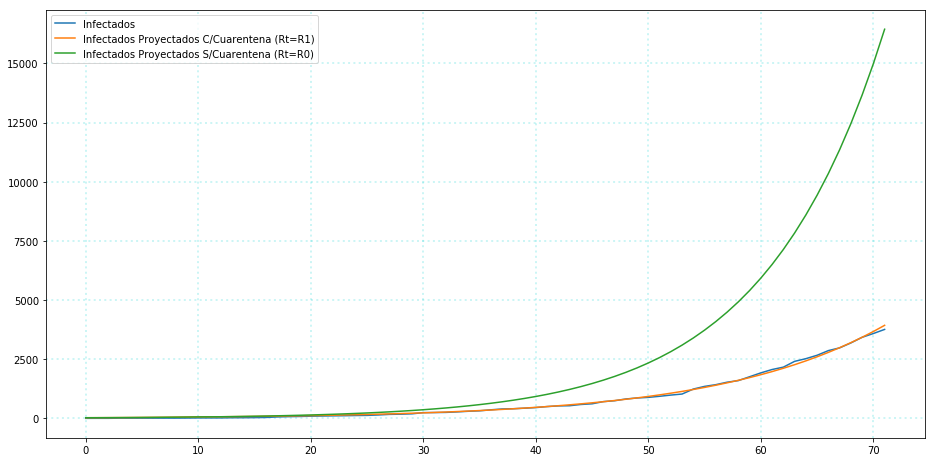

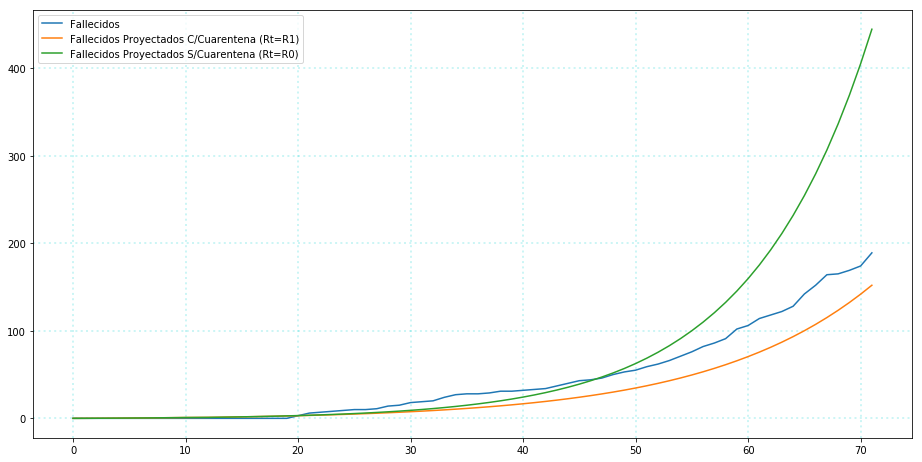

In [3]:
import scipy.optimize

def process_solution(solution):
    infected = solution['y'][1] + solution['y'][2]
    return {
        't': solution['t'],
        # base
        'susceptible': solution['y'][0],
        'exposed': solution['y'][1],
        'infectious': solution['y'][2],
        'recovered': solution['y'][3],
        'death': solution['y'][4],
        # +
        'infected': infected,
        'new_cases': np.diff(
            infected, prepend=[infected[0]]
        )
    }

def run_model(args):
    infectados_t0, R_t0, R_t1 = args
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R_t0,
        infectados_t0,
        0, 0
    )
    solution = run(
        seir_model,
        SEIR_t0,
        beta = [R0 / periodo_infeccioso for R0 in (R_t0, R_t1)],
        sigma = 1 / periodo_incubacion,
        gamma = 1 / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        days = days,
        step = 1
    )
    return process_solution(solution)

def naive_fit():
    def sqsum(R_ts):
        solution = run_model(R_ts)
        
        return sum((solution['infected'] - data[0]) ** 2)
    
    return scipy.optimize.minimize(
        sqsum, (5., 3., 3.), method='TNC', bounds=((5., 30.), (2.4, 4.2), (1.2, 3.2))
    ).x


R_ts_6 = naive_fit()
solution_composed = run_model(R_ts_6)

infectados_t0, R_t0, _ = R_ts_6
solution_simple = run_model((infectados_t0, R_t0, R_t0))

plot(
    solution_composed['t'], 
    data[0], solution_composed['infected'], solution_simple['infected'],
    labels=[
        'Infectados', 
        'Infectados Proyectados C/Cuarentena (Rt=R1)', 
        'Infectados Proyectados S/Cuarentena (Rt=R0)',
    ]
)

plot(
    solution_composed['t'], 
    data[2], solution_composed['death'], solution_simple['death'],
    labels=[
        'Fallecidos',
        'Fallecidos Proyectados C/Cuarentena (Rt=R1)',
        'Fallecidos Proyectados S/Cuarentena (Rt=R0)'
    ]
)
print('Infectados en tiempo 0: {}\nR0: {}\nR1: {}'.format(*R_ts_6))

Para ajustar el modelo a los datos usamos una funcion que calcule la suma de las diferencias de los datos al cuadrado y buscamos los valores que minimicen esa diferencia.  
El numero de infectados iniciales para el modelo no tiene mucho sentido al ser real y no entero pero se trabaja con lo que se tiene.  
Los resultados todavia son demasiado altos.

La razon de mortalidad reportada por varios paises varia entre el 1% y el 4% (algunos paises reportan una razon < 1%).  
<b>Como se comporta el modelo si ajustamos la cantidad de fallecidos  a ese rango?<b>

Mortalidad 1%
Infectados en tiempo 0: 72.11970313129936
R0: 3.672088261614835
R1: 2.1454754730166297


Mortalidad 4%
Infectados en tiempo 0: 27.46700905760879
R0: 2.900180808785066
R1: 2.1970787132490277


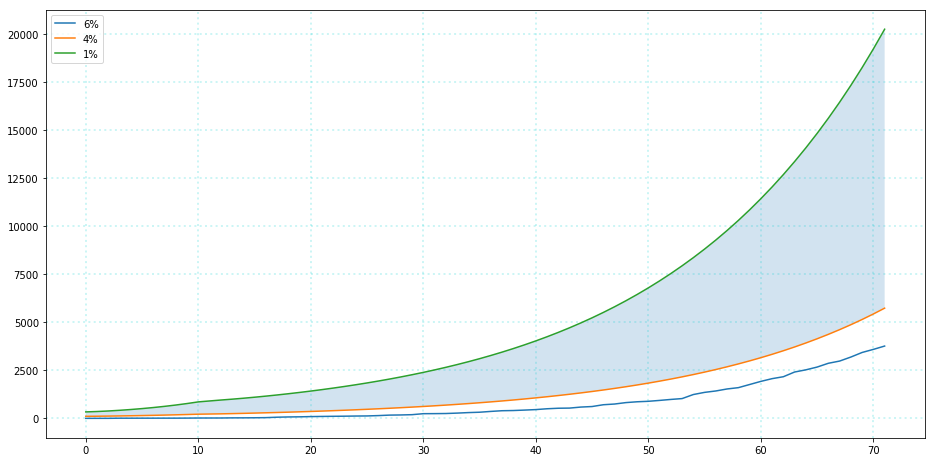

In [4]:
def naive_fit():
    def sqsum(R_ts):
        solution = run_model(R_ts)
        return sum((solution['death'] - data[2]) ** 2)
    
    return scipy.optimize.minimize(
        sqsum, (5., 3., 3.), method='TNC', bounds=((16., 75.), (2.4, 4.2), (1.2, 3.2))
    ).x

razon_mortalidad = 1 / 100.0
R_ts_1 = naive_fit()

razon_mortalidad = 4 / 100.0
R_ts_4 = naive_fit()

solution_1 = run_model(R_ts_1)
solution_4 = run_model(R_ts_4)

ax = plot(
    solution_4['t'], 
    data[0], solution_4['infected'], solution_1['infected'],
    labels = ['6%', '4%', '1%']
)
ax.fill_between(
    solution_4['t'],
    solution_1['infected'],
    solution_4['infected'],
    alpha=0.2
)

print('Mortalidad 1%\nInfectados en tiempo 0: {}\nR0: {}\nR1: {}\n\n'.format(*R_ts_1))
print('Mortalidad 4%\nInfectados en tiempo 0: {}\nR0: {}\nR1: {}'.format(*R_ts_4))

Aqui ajustamos el modelo a la curva de mortalidad y graficamos los infectados en el caso de mortalidad del 1% y el 4%.  
Mortalidad del 1% suena algo irreal en este momento, ~ 30% de los fallecidos son de provincia y algunos no fueron diagnosticados hasta despues de fallecer.

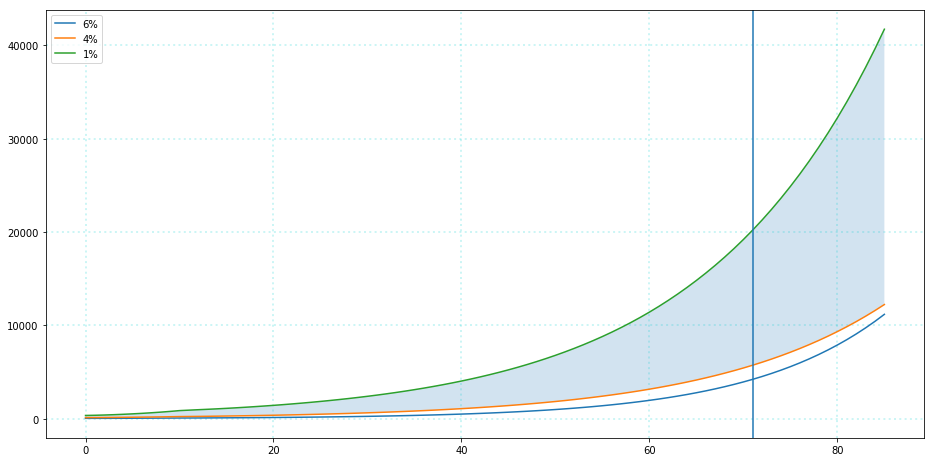

In [5]:
days[1] = len(data[0]) - days[0] + 7 * 2
    
solution_original = run_model(R_ts_6)
solution_1 = run_model(R_ts_1)
solution_4 = run_model(R_ts_4)

ax = plot(
    solution_original['t'], 
    solution_original['infected'], solution_4['infected'], solution_1['infected'],
    labels = ['6%', '4%', '1%']
)

ax.fill_between(
    solution_4['t'],
    solution_1['infected'],
    solution_4['infected'],
    alpha=0.2,
)
_ = ax.axvline(len(data[0]))

Proyeccion 14 dias, <b>mucho puede cambiar y la sensibilidad a los datos iniciales es muy alta.</b>  
<b>Cuando se superarian los 120 infectados dia?</b>

In [6]:
print('Siguiendo la mortalidad del 6% el dia: {}'.format(
    min(np.where(solution_original['new_cases'] > 120)[0])
))
print('Siguiendo la mortalidad del 4% el dia: {}'.format(
    min(np.where(solution_4['new_cases'] > 120)[0])
))
print('Siguiendo la mortalidad del 1% el dia: {}'.format(
    min(np.where(solution_1['new_cases'] > 120)[0])
))

Siguiendo la mortalidad del 6% el dia: 58
Siguiendo la mortalidad del 4% el dia: 53
Siguiendo la mortalidad del 1% el dia: 29


Notas:
* Sigue faltando fichar muchas de las cosas del primer notebook
* No introduje la re-susceptibilidad :S

Que hacer ahora?
* Agregar razon de deteccion, y razon de infeccion de casos detectados
* Hay datos sobre los contactos sospechosos/dia centralizado?